In [1]:
#Headers for the analysis
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option("mode.chained_assignment", None)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
import skfuzzy as fuzz
import statsmodels.api as sm
import numpy as np
import pandas as pd
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from sklearn.svm import SVR




from numpy import array
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
from keras.layers import Dense, LSTM
from keras.models import Sequential
from keras.layers import Input

from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers import Conv1D
from keras.layers import MaxPooling1D

np.random.seed(1234)
tf.random.set_seed(1234)

import timeit



2024-07-19 14:13:44.141165: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-19 14:13:44.162308: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-19 14:13:44.162327: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-19 14:13:44.162346: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-19 14:13:44.166667: I tensorflow/core/platform/cpu_feature_g

In [2]:
#Filler functions
def rmse(predictions, targets):
    return np.sqrt(mean_squared_error(targets, predictions))#, squared=False)
# Fixed values for the device, not going to change based on our requirement

freq_dict = {}
freq_dict['gFreq'] = [177000000,266000000,350000000,420000000,480000000,600000000]
freq_dict['mFreq'] = [165000000,206000000,275000000,413000000,543000000,633000000,728000000,825000000]#,933000000]
freq_dict['sFreq'] = [200000,300000,400000,500000,600000,700000,800000,900000,1000000,1100000,1200000,1300000,1400000]
freq_dict['bFreq'] = [200000,300000,400000,500000,600000,700000,800000,900000,1000000,1100000,1200000,1300000,1400000,1500000,1600000,1700000,1800000,1900000,2000000]
# cost_list =['cCost','mCost','gCost']
cFreq = 'bFreq'
mFreq = 'mFreq'
gFreq = 'gFreq'

cost2FMap = {}
cost2FMap['cCost'] = 'bFreq'
cost2FMap['mCost'] = 'mFreq'
cost2FMap['gCost'] = 'gFreq'

## Function to extract the files and send a dataframe

def extractDatafromFile(fileName='./UtilTestFinal',padding=0): ## Generally make the padding 0
    new_data = pd.read_csv(fileName)
    #### This part needs to be 
    if padding == 1:  # if there is not 
        new_data['cCost'] =  new_data['bUtil']*new_data['bFreq']/2000000
        new_data['mCost'] = new_data['mUtil']*new_data['mFreq']/825000000
        new_data['gCost'] = 0
        new_data['gFreq'] = 600000000

    return new_data

#extractDatafromFile()
# Getting the exog list for analysis

def getExog(endog='cCost'):
    cost_list =['cCost','mCost','gCost']
    if endog not in cost_list:
        print("Incorrect Value")
        return None,None
    else:
        my_list = []
        for res in cost_list:
            if res != endog:
                my_list.append(res)
        return my_list[0],my_list[1]

# getExog('gCost')

## Function to shift the data, enabling testing and trainig

def createRequiredDataSet(input_df,endog,shiftAR,shiftARX,b_exog=True):
    modified_df = pd.DataFrame()
    ## Get the exog values
    exog,exog1 = getExog(endog)
    if b_exog == True:
        modified_df = input_df[[endog,exog,exog1]]
    else:
        modified_df = input_df[[endog]]
    # Shifting the endog data
    for i in range(1,shiftAR+1):
        modified_df['%s_%d'%(endog,i)] = modified_df[endog].shift(i)
    if b_exog==True:
    # Shifting the exog and exog1 data
        modified_df[exog] = modified_df[exog].shift(1)
        modified_df[exog1] = modified_df[exog1].shift(1)
    
        for i in range(1,shiftARX+1):
            modified_df['%s_%d'%(exog,i)] = modified_df[exog].shift(i+1)
            modified_df['%s_%d'%(exog1,i)] = modified_df[exog1].shift(i+1)

    # Adding the frequency stuff
    modified_df[cFreq] = input_df[cFreq] 
    modified_df[mFreq] = input_df[mFreq] 
    modified_df[gFreq] = input_df[gFreq] 
    modified_df = modified_df.dropna()
    return modified_df


## Test_train divide

def test_train_split(input_df,trainIDX,testIDX,perc=0.8):
    totalLen = len(input_df)
    if trainIDX == -1 or testIDX == -1:
        trainIDX = int(perc*totalLen)
        testIDX = int(perc*totalLen)
    train_df = input_df.iloc[:trainIDX,:]
    test_df = input_df.iloc[testIDX:,:]
    return train_df,test_df


## get the matrices for training, we are assuming that 0 is the y value and the rest are x, we can choose to skip few columns

def getYXData(input_df,ignoreCols=0):
    totalLen = len(input_df.columns)
    y_data = input_df.iloc[:,0].to_numpy()
    x_data = input_df.iloc[:,1:totalLen-ignoreCols].to_numpy()
    return y_data,x_data


def train_Cluster(data, n_cluster = 5):
    # print("The stats of the training data: features {} and size {}".format(len(data[0]), len(data)))
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T, n_cluster, 2, error=0.005, maxiter=1000, init=None, seed = 0)
    # print("The centroid values are \n {}".format(cntr))
    return cntr,u


def simple_train(yData, xData, weight=None):
    if weight is None:
        weight = np.ones(len(yData))

    new_x = sm.add_constant(xData)
    model = sm.WLS(yData,new_x,weights=weight)
    result = model.fit()
    return result



def simple_test_single(model, xData):
    newX = [1.0]
    newX.extend(xData)
    y_pred = model.get_prediction(newX).predicted_mean
    return y_pred

def getSingleCluster(data, cntr):
    ut,u0t,dt,jmt,pt,fpct = fuzz.cluster.cmeans_predict(np.array([data]).T,cntr,2,error=0.005,maxiter=1000,init=None,seed=0)
    return ut


def prediction(model,x,cluster):
    ## get cluster
    N_CLUST = len(model)
    prob_d = getSingleCluster(x,cluster).T[0]
    y = []
    for i in range(N_CLUST):
        ys = simple_test_single(model[i],x)
        y.append(ys*prob_d[i])
    my_pred = min(sum(y)[0],100.0)
    return my_pred


# Prediction of just simple Mean
def prediction_mean(x,hist):
    ## get cluster
    # N_CLUST = len(model)
    # prob_d = getSingleCluster(x,cluster).T[0]
    # y = []
    # for i in range(N_CLUST):
    #     ys = simple_test_single(model[i],x)
    #     y.append(ys*prob_d[i])
    my_pred = np.mean(x[:hist])
    return my_pred

In [39]:
# def getPredF(est_util, act_util, freq_list):
#     eff_u = -1
#     max_f = max(freq_list)
#     est_freq = max_f
#     for f in freq_list:
#         eff_u = est_util * max_f/f
#         if eff_u <=100 or f == max_f:
#             eff_y = act_util * max_f/f
#             return f,eff_u,eff_y
#     return max_f,-1,-1
def getPredF(est_util, act_util, freq_list): ## Take the higher frequency if possible
    eff_u = -1
    max_f = max(freq_list)
    est_freq = max_f
    for fidx in range(len(freq_list)):
        f = freq_list[fidx]
        eff_u = est_util * max_f/f
        if eff_u <=100 or f == max_f:
            eff_y = act_util * max_f/freq_list[min(fidx+1,len(freq_list)-1)]
            return f,eff_u,eff_y
    return max_f,-1,-1
def energy_perf_analysis(y_act,y_est,act_freq,endog, details=False):
    eff_util = []
    est_freq = []
    possible_freq_config = freq_dict[cost2FMap[endog]] ## list of all possible frequency in increasing order
    LEN = len(y_act)
    energy_save = 0.
    for idx in range(LEN):
        pred_f, eff_u, eff_y = getPredF(y_est[idx],y_act[idx],possible_freq_config)
        eff_util.append(eff_y)
        est_freq.append(pred_f)
        # print(pred_f, act_freq[idx])
        energy_save += math.ceil(eff_y/100.) * (pred_f/act_freq[idx])**2
        
        
    stall = (sum( i > 100 for i in eff_util ) * 100) / LEN
    energy_ratio = 1.0 - (energy_save/LEN)
    if details:
        return stall, energy_ratio, est_freq, eff_util
    return stall, energy_ratio

    
## Plot the error
def plotErrDist(y_est,y_actual,bins=10):
    err = np.array(y_est) - np.array(y_actual)
    print("min:",min(err),", max : ",max(err))
    ybins, xbins, bar = plt.hist(err, color='lightblue', ec='black', bins=bins)
    print("Mode error: ", xbins[np.argmax(ybins)])
    plt.show()
    return
    

In [3]:
# ##n imports

# from numpy import array
# import tensorflow as tf
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
# from keras.layers import Dense, LSTM
# from keras.models import Sequential
# from keras.layers import Input

# from keras.layers import Flatten
# from keras.layers import TimeDistributed
# from keras.layers import Conv1D
# from keras.layers import MaxPooling1D
# np.random.seed(1234)
# tf.random.set_seed(1234)

## Lets do univariate models


def getUnivariateDataSplit(listData, shiftAR=8): # This will create a new df so that we can run the LSTM
    modified_df = pd.DataFrame()
    modified_df['endog'] = listData
    for i in range(1,shiftAR+1):
        modified_df['endog_%d'%(i)] = modified_df['endog'].shift(i)
        
    modified_df = modified_df.dropna()
    return modified_df
    

    


# def LSTM(x_train,y_train,x_test,y_test):
#     pass



In [11]:
my_test = extractDatafromFile('./UtilTRNS.csv',0)
# MyData = getUnivariateDataSplit(my_test['cCost'].to_numpy(), shiftAR=8)
MyData = createRequiredDataSet(my_test,'cCost',8,-1,False)
train_df,test_df = test_train_split(MyData,trainIDX=1000,testIDX=1000,perc=0.0)
y_train,x_train = getYXData(train_df,ignoreCols=3)
y_test,x_test = getYXData(test_df,ignoreCols=3)
#Reshape the data
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1],1)
#LSTM 
n_steps = x_train.shape[1]
n_features = 1
# define model
model = Sequential()
model.add(LSTM(50, input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(x_train, y_train, epochs=25, verbose=0)

In [8]:
x_test_T = x_test[:200]
# x_test_r = x_test_T.reshape(200,n_steps,1)
yhat = model.predict(x_test_T, verbose=0)
# yhat
# yhat = np.array(yhat)
yOut = yhat.reshape(-1)
# yOut
rmse(yOut,y_test[:200])

38.774860501320525

In [9]:
## A different LSTM modeling ... with Conv Neural Network 

# Steps -- try to get the pipeline running....
my_test = extractDatafromFile('./UtilTestFinal',1)
MyData = getUnivariateDataSplit(my_test['cCost'].to_numpy(), shiftAR=8)
train_df,test_df = test_train_split(MyData,trainIDX=5000,testIDX=5000,perc=0.0)
y_train,x_train = getYXData(train_df)
y_test,x_test = getYXData(test_df)
#Reshape the data
n_features = 1
n_steps = 4
n_seq = 2
x_train = x_train.reshape(x_train.shape[0], n_seq, n_steps,n_features)
x_test = x_test.reshape(x_test.shape[0],n_seq, n_steps,n_features)
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
#fit model
model.fit(x_train, y_train, epochs=25, verbose=0)




In [23]:
x_test_T = x_test[:2000]
# x_test_r = x_test_T.reshape(2000,n_steps,1)
yhat = model.predict(x_test_T, verbose=0)
# yhat
# yhat = np.array(yhat)
yOut = yhat.reshape(-1)
# yOut
rmse(yOut,y_test[:2000])

9.945937038403176

In [5]:
## LSTM Modeling....

my_test = extractDatafromFile('./UtilTestFinal',1)
Mod = createRequiredDataSet(my_test,endog='mCost',shiftAR=8,shiftARX=3)
train_df,test_df = test_train_split(Mod,trainIDX=5000,testIDX=7500,perc=0.0)
y_train,x_train = getYXData(train_df,ignoreCols=3)
y_test,x_test = getYXData(test_df,ignoreCols=3)


## This might not be the best data respresentation, but we will get into it if requried.

## Train the SVR
TEST_LEN = 500


scaler = StandardScaler().fit(x_train)
X_train_scaled = scaler.transform(x_train)
X_test_scaled = scaler.transform(x_test)

X_test_scaled_T = X_test_scaled[:TEST_LEN]


svr_rbf = SVR(kernel = 'rbf')
svr_rbf.fit(X_train_scaled, y_train)

SVR()

In [6]:
my_test = extractDatafromFile('./UtilTestFinal',1)
Mod = createRequiredDataSet(my_test,endog='cCost',shiftAR=8,shiftARX=3)
train_df,test_df = test_train_split(Mod,trainIDX=5000,testIDX=7500,perc=0.0)
y_train,x_train = getYXData(train_df,ignoreCols=3)
y_test,x_test = getYXData(test_df,ignoreCols=3)

## Train the SVR
TEST_LEN = 500


scaler = StandardScaler().fit(x_train)
X_train_scaled = scaler.transform(x_train)
X_test_scaled = scaler.transform(x_test)

X_test_scaled_T = X_test_scaled[:TEST_LEN]


svr_rbf = SVR(kernel = 'rbf')
svr_rbf.fit(X_train_scaled, y_train)
    

SVR()

In [28]:
# svr_rbf.predict(X_test_scaled_T)

In [29]:
# y_test[:TEST_LEN]

# Pipelined Approach 

In [4]:
def ModelPipeline_LSTM(fileName,padding=0,endog='cCost',N_CLUST=5,shiftAR=5,shiftARX=3,trainIDX=5000,testIDX=5000,TEST_LEN = 50, energy=True):
    my_test = extractDatafromFile(fileName,padding)
    if shiftAR%2 == 1:
        shiftAR += 1
    MyData = createRequiredDataSet(my_test,endog,shiftAR,-1,False)
    train_df,test_df = test_train_split(MyData,trainIDX,testIDX,perc=0.0)
    y_train,x_train = getYXData(train_df,ignoreCols=3)
    y_test,x_test = getYXData(test_df,ignoreCols=3)
    #Reshape the data
    n_features = 1
    n_seq = 2
    n_steps = shiftAR//n_seq   
    x_train = x_train.reshape(x_train.shape[0], n_seq, n_steps,n_features)
    x_test = x_test.reshape(x_test.shape[0],n_seq, n_steps,n_features)
    #Train and fit the model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    #fit model
    start = timeit.default_timer()
    model.fit(x_train, y_train, epochs=25, verbose=0)
    stop = timeit.default_timer()

    print('Train Time: ', stop - start) 
    

    #Prediction using the model
    ys_actual = y_test[:TEST_LEN]
    x_test_T = x_test[:TEST_LEN]
    # x_test_r = x_test_T.reshape(2000,n_steps,1)
    ys_est = model.predict(x_test_T, verbose=0)
    ys_est = ys_est.reshape(-1)
    
    if energy:
        ys_freq = test_df[cost2FMap[endog]].to_numpy()[:TEST_LEN] # the actual frequency we observed
        ##  Do something with energy values and frequency values
        stall, energy, est_freq, eff_util  = energy_perf_analysis(ys_actual,ys_est,ys_freq,endog,details=True)
        return ys_est,ys_actual,rmse(ys_est,ys_actual), est_freq, ys_freq, eff_util, stall,energy
        
    return ys_est,ys_actual,rmse(ys_est,ys_actual)

In [5]:
def ModelPipeline_SVR(fileName,padding=0,endog='cCost',Kernel='rbf',N_CLUST=5,shiftAR=5,shiftARX=3,trainIDX=5000,testIDX=5000,TEST_LEN = 50, energy=True):
    my_test = extractDatafromFile(fileName,padding) # set to 1 for most of the data, except for the case where there is no GPU
    Mod = createRequiredDataSet(my_test,endog,shiftAR,shiftARX)
    train_df,test_df = test_train_split(Mod,trainIDX,testIDX,perc=0.0)
    y_train,x_train = getYXData(train_df,ignoreCols=3)
    y_test,x_test = getYXData(test_df,ignoreCols=3)
    ### Get the clusters
    # cluster_center,prob = train_Cluster(x_train[:,:],n_cluster = N_CLUST)
    ### Train the Model
    start = timeit.default_timer()
    scaler = StandardScaler().fit(x_train)
    X_train_scaled = scaler.transform(x_train)
    X_test_scaled = scaler.transform(x_test)
    svr = SVR(kernel = Kernel)
    svr.fit(X_train_scaled, y_train)
    stop = timeit.default_timer()
    print('Train Time: ', stop - start) 
    # model = []
    # for i in range(N_CLUST):
    #     out_model = simple_train(y_train,x_train,weight = prob[i,:])
    #     model.append(out_model)

    ### Test the models
    ys_actual = y_test[:TEST_LEN]
    X_test_scaled_T = X_test_scaled[:TEST_LEN]
    ys_est = svr.predict(X_test_scaled_T)
    # ys_est = []
    # for id in range(TEST_LEN):
    #     predVal = prediction(model,x_test[id],cluster_center)
    #     ys_est.append(predVal)
    # print(cost2FMap[endog])        
    if energy:
        ys_freq = test_df[cost2FMap[endog]].to_numpy()[:TEST_LEN] # the actual frequency we observed
        ##  Do something with energy values and frequency values
        stall, energy, est_freq, eff_util  = energy_perf_analysis(ys_actual,ys_est,ys_freq,endog,details=True)
        return ys_est,ys_actual,rmse(ys_est,ys_actual), est_freq, ys_freq, eff_util, stall,energy
        
    ##
    
    return ys_est,ys_actual,rmse(ys_est,ys_actual)

In [6]:
def ModelPipeline_Mean(fileName,padding=0,endog='cCost',N_CLUST=5,shiftAR=5,shiftARX=3,trainIDX=5000,testIDX=5000,TEST_LEN = 50, energy=True):
    my_test = extractDatafromFile(fileName,padding) # set to 0 for most of the data, unless no GPU present
    Mod = createRequiredDataSet(my_test,endog,shiftAR,shiftARX)
    train_df,test_df = test_train_split(Mod,trainIDX,testIDX,perc=0.0)
    y_train,x_train = getYXData(train_df,ignoreCols=3)
    y_test,x_test = getYXData(test_df,ignoreCols=3)
    ### Get the clusters
    # cluster_center,prob = train_Cluster(x_train[:,:],n_cluster = N_CLUST)
    # ### Train the Model
    # model = []
    # for i in range(N_CLUST):
    #     out_model = simple_train(y_train,x_train,weight = prob[i,:])
    #     model.append(out_model)

    ### Test the models
    ys_actual = y_test[:TEST_LEN]
    ys_est = []
    for id in range(TEST_LEN):
        predVal = prediction_mean(x_test[id],shiftAR)
        ys_est.append(predVal)
    # print(cost2FMap[endog])        
    if energy:
        ys_freq = test_df[cost2FMap[endog]].to_numpy()[:TEST_LEN] # the actual frequency we observed
        ##  Do something with energy values and frequency values
        stall, energy, est_freq, eff_util  = energy_perf_analysis(ys_actual,ys_est,ys_freq,endog,details=True)
        return ys_est,ys_actual,rmse(ys_est,ys_actual), est_freq, ys_freq, eff_util, stall,energy
        
    ##
    
    return ys_est,ys_actual,rmse(ys_est,ys_actual)

In [10]:
def ModelPipeline(fileName,padding=0,endog='cCost',N_CLUST=5,shiftAR=5,shiftARX=3,trainIDX=5000,testIDX=5000,TEST_LEN = 50, energy=True):
    my_test = extractDatafromFile(fileName,padding) # set to 0 for most of the data, unless no GPU present
    Mod = createRequiredDataSet(my_test,endog,shiftAR,shiftARX)
    train_df,test_df = test_train_split(Mod,trainIDX,testIDX,perc=0.0)
    y_train,x_train = getYXData(train_df,ignoreCols=3)
    y_test,x_test = getYXData(test_df,ignoreCols=3)
    ### Get the clusters
    start = timeit.default_timer()
    cluster_center,prob = train_Cluster(x_train[:,:],n_cluster = N_CLUST)
    ### Train the Model
    model = []
    for i in range(N_CLUST):
        out_model = simple_train(y_train,x_train,weight = prob[i,:])
        model.append(out_model)
    stop = timeit.default_timer()
    print('Train Time: ', stop - start) 
    ### Test the models
    ys_actual = y_test[:TEST_LEN]
    ys_est = []
    for id in range(TEST_LEN):
        predVal = prediction(model,x_test[id],cluster_center)
        ys_est.append(predVal)
    # print(cost2FMap[endog])        
    if energy:
        ys_freq = test_df[cost2FMap[endog]].to_numpy()[:TEST_LEN] # the actual frequency we observed
        ##  Do something with energy values and frequency values
        stall, energy, est_freq, eff_util  = energy_perf_analysis(ys_actual,ys_est,ys_freq,endog,details=True)
        return ys_est,ys_actual,rmse(ys_est,ys_actual), est_freq, ys_freq, eff_util, stall,energy
        
    ##
    
    return ys_est,ys_actual,rmse(ys_est,ys_actual)

In [15]:
y_est,y_act,err,est_freq, act_freq,eff_util,stall,energy = ModelPipeline('./UtilTestFinal',padding=1,\
                                                                         endog='cCost',N_CLUST=3,shiftAR=10,shiftARX=3,\
                                                                         trainIDX=5000,testIDX=5000,TEST_LEN = 2000)

Train Time:  0.05177474592346698


In [44]:
## 
file='./UtilTestFinal'
pad = 1
test_endog = 'mCost'
TrIDX = 5000
TIDX = 5000
TLEN = 2000

Train Time:  0.00985112099442631
#AR  2  RMSE : 4.062721918738198
min: -40.85839307336734 , max :  46.04907543496028
Mode error:  -0.30157443614778856


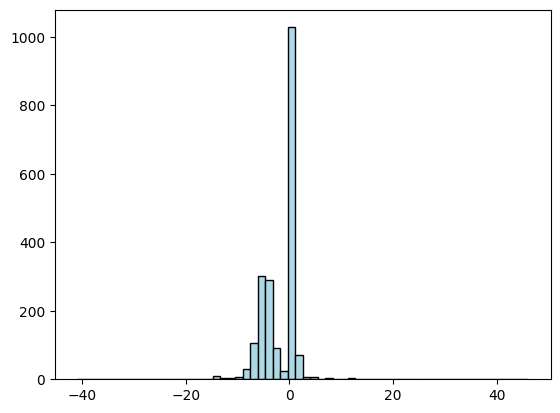

Train Time:  0.011517583043314517
#AR  3  RMSE : 3.460670228736561
min: -41.01068983020693 , max :  48.42990596319843
Mode error:  -0.7624217231745192


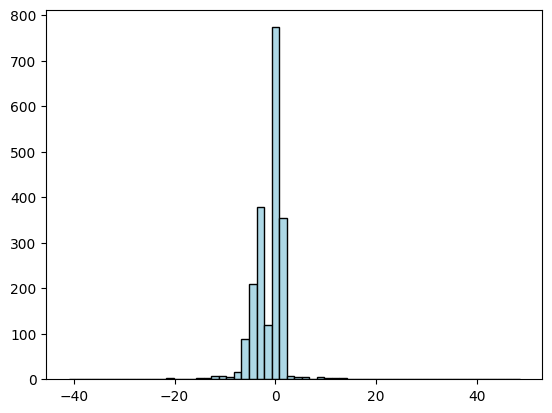

Train Time:  0.012429710943251848
#AR  4  RMSE : 3.126956781443893
min: -41.38910533203283 , max :  49.49173538516145
Mode error:  -0.49272700929540747


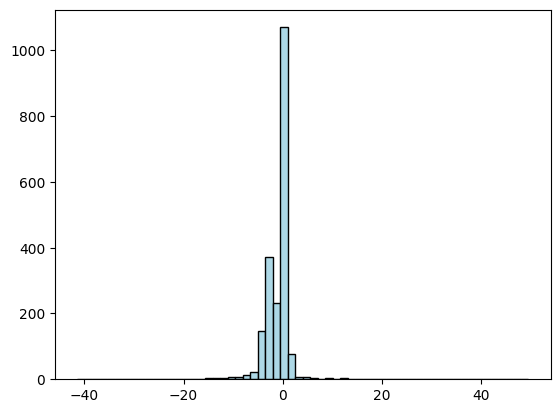

Train Time:  0.013446382945403457
#AR  5  RMSE : 3.1166907177455774
min: -41.25491276358174 , max :  49.51155183580586
Mode error:  -0.4100036938573268


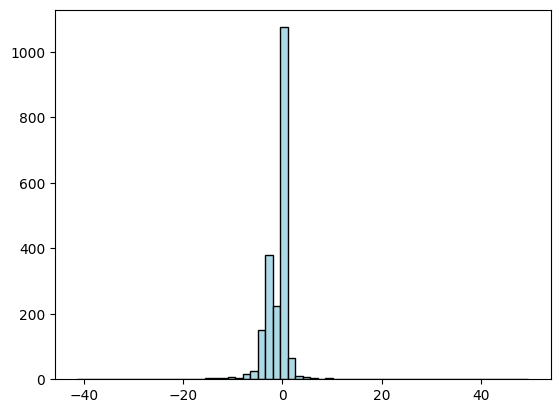

Train Time:  0.013083396013826132
#AR  6  RMSE : 3.3018414742527256
min: -40.247444033813295 , max :  49.1363645114317
Mode error:  -0.02473018845304864


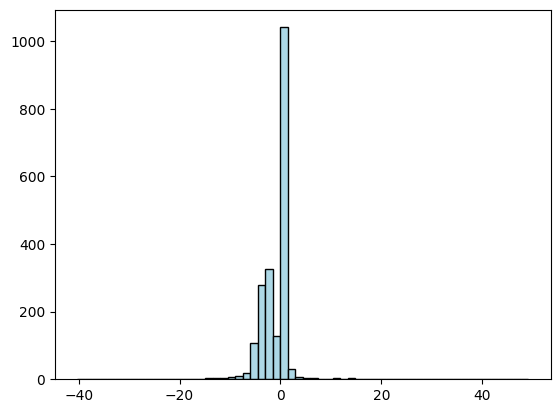

Train Time:  0.012970651034265757
#AR  7  RMSE : 3.258340113180974
min: -40.452266660844884 , max :  49.41530288181044
Mode error:  -0.011860366649990794


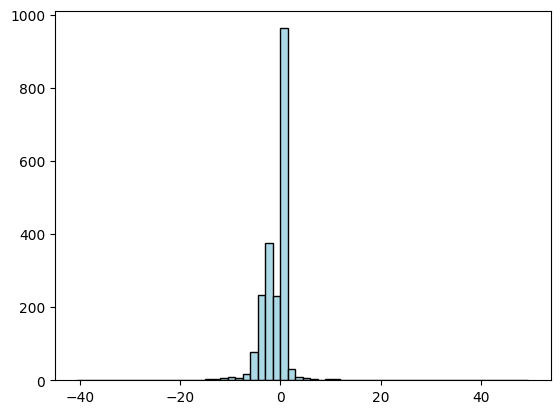

Train Time:  0.013573089032433927
#AR  8  RMSE : 3.269628110616167
min: -40.3465239866167 , max :  49.34108002628243
Mode error:  0.012897819187905668


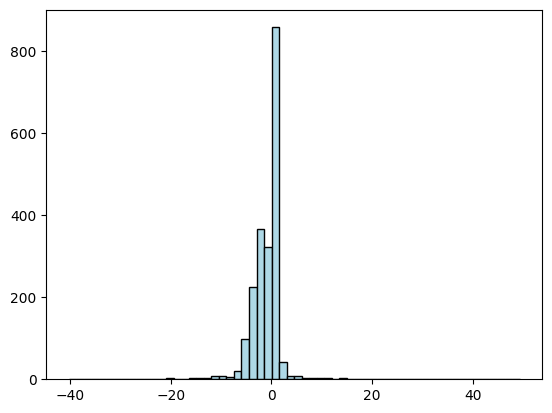

Train Time:  0.014412533957511187
#AR  9  RMSE : 3.2987037742789194
min: -40.44137487521323 , max :  49.20625146810598
Mode error:  -0.09994302071957861


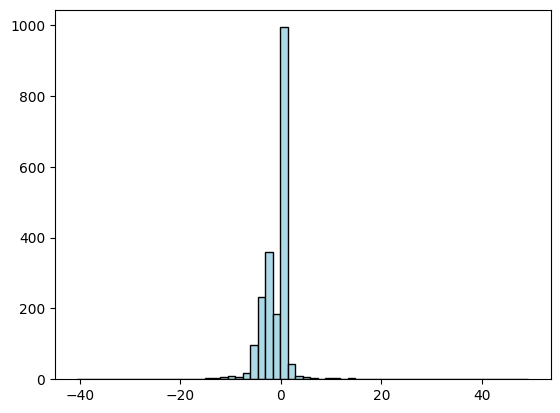

Train Time:  0.01493885600939393
#AR  10  RMSE : 3.3104804055836277
min: -40.51762227119252 , max :  49.10560332659332
Mode error:  -0.1871707521888908


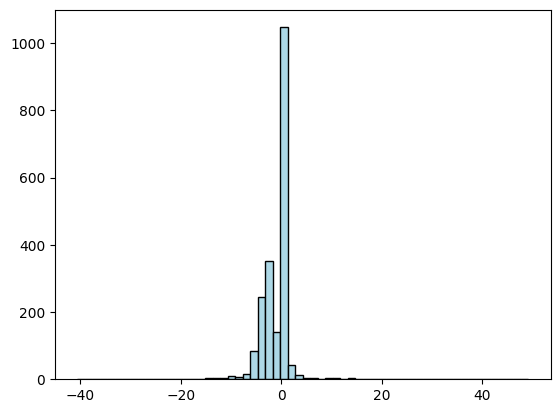

Train Time:  0.016454881988465786
#AR  11  RMSE : 3.4110792763883238
min: -40.51972991472337 , max :  48.743125951719044
Mode error:  -0.35144477482428726


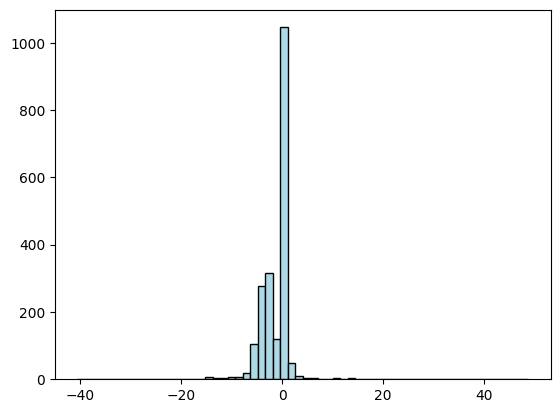

Train Time:  0.01744434703141451
#AR  12  RMSE : 3.4187068154578295
min: -40.562288236652066 , max :  48.74226948509799
Mode error:  -0.375237261864541


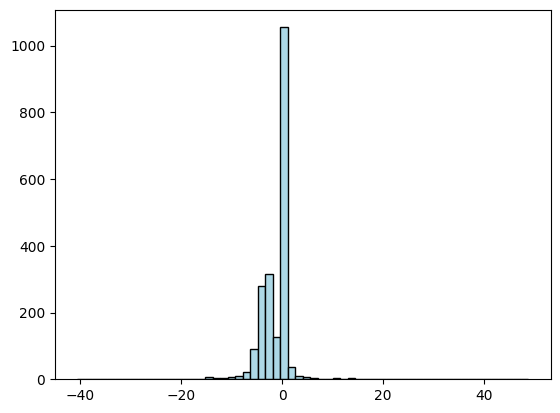

Train Time:  0.018599724979139864
#AR  13  RMSE : 3.2037020927676663
min: -41.22256155917147 , max :  49.57666981625205
Mode error:  -0.3629074402308845


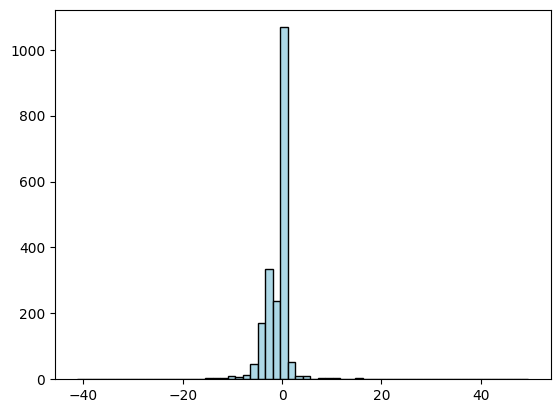

Train Time:  0.020276420982554555
#AR  14  RMSE : 3.262808644496139
min: -42.65450058608352 , max :  50.006012456775586
Mode error:  -0.9572697167969224


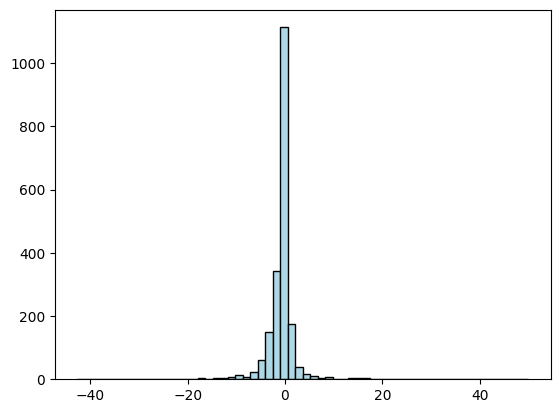

Train Time:  0.0213319119066
#AR  15  RMSE : 3.307883027819501
min: -43.00987232253722 , max :  50.20054782923683
Mode error:  -1.065183254238896


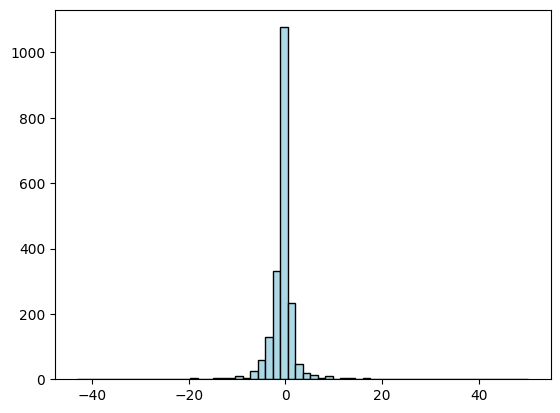

In [45]:
my_data = []
for val in range(2,16):
    y_est,y_act,rms,est_freq, act_freq,eff_util,stall,energy= ModelPipeline(file,padding=pad,\
                                                                            endog=test_endog,N_CLUST=2,shiftAR=val,shiftARX=val-5,\
                                                                            trainIDX=TrIDX,testIDX=TIDX,TEST_LEN = TLEN)
    print("#AR ",val," RMSE :", rms)
    plotErrDist(y_est,y_act,60)
    data = (val,rms,stall,energy)
    my_data.append(data)
    

#AR  2  RMSE : 14.53837195868267
min: -41.0 , max :  50.0
Mode error:  -0.05000000000000426


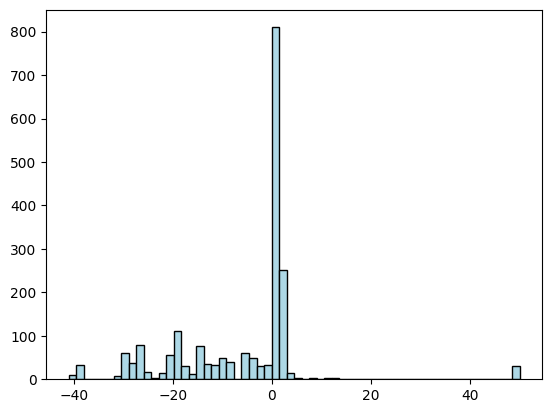

#AR  3  RMSE : 9.831659783844215
min: -28.666666666666664 , max :  48.03393939393939
Mode error:  -0.5431111111111129


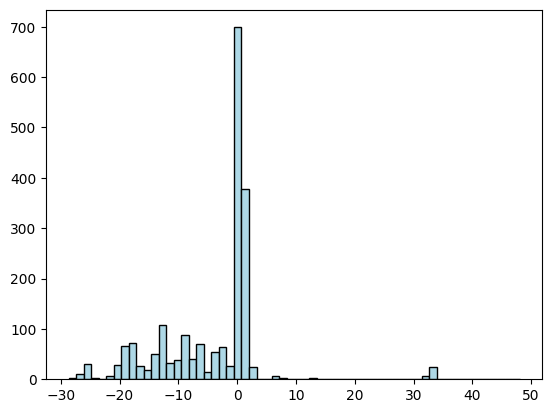

#AR  4  RMSE : 7.606193076033323
min: -28.0 , max :  48.36727272727273
Mode error:  0.0013333333333349628


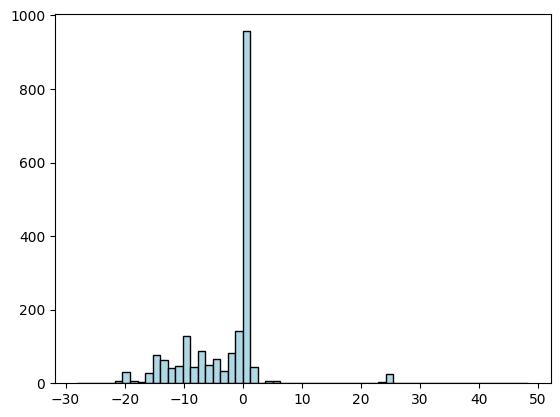

#AR  5  RMSE : 6.404905367442909
min: -30.466666666666665 , max :  49.96727272727273
Mode error:  0.36634343434343464


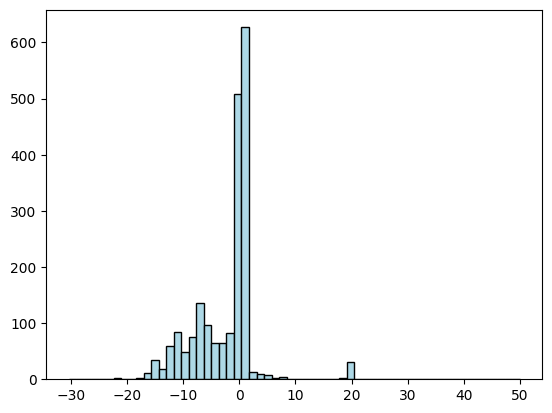

#AR  6  RMSE : 5.726165435383728
min: -34.138585858585856 , max :  51.03393939393939
Mode error:  -0.0695757575757554


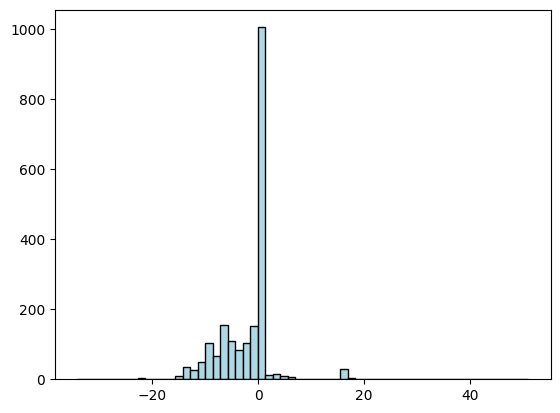

#AR  7  RMSE : 5.355907324641076
min: -36.94735930735931 , max :  51.79584415584416
Mode error:  0.028975468975467322


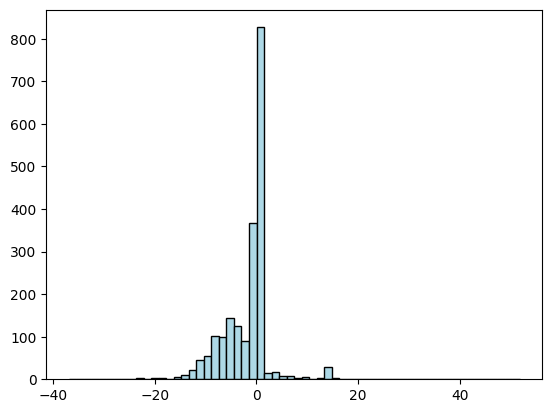

#AR  8  RMSE : 5.179042408688644
min: -39.053939393939395 , max :  52.36727272727273
Mode error:  -0.9617676767676784


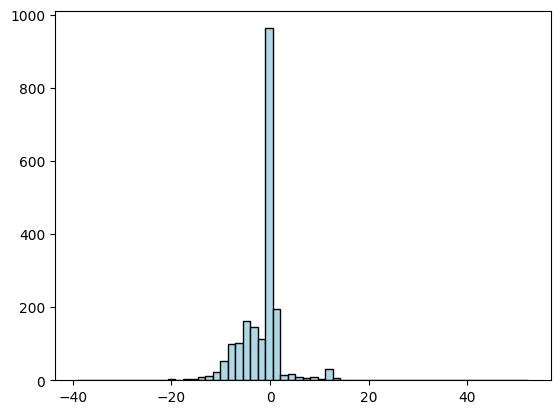

#AR  9  RMSE : 5.12351068183119
min: -40.64053872053872 , max :  52.81171717171717
Mode error:  -0.14456116722783463


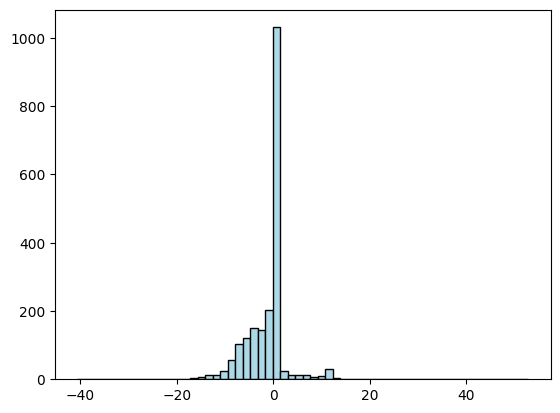

#AR  10  RMSE : 5.145701722151828
min: -41.95648484848485 , max :  53.167272727272724
Mode error:  -0.736189898989899


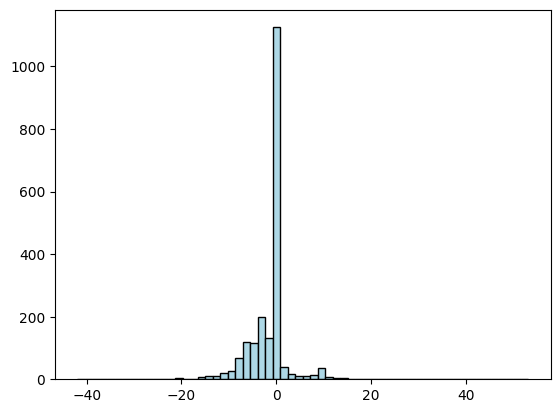

#AR  11  RMSE : 5.209154932519911
min: -42.9603305785124 , max :  53.45818181818182
Mode error:  -1.1789752066115753


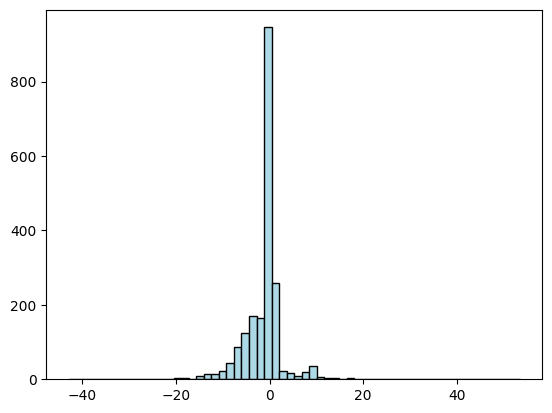

#AR  12  RMSE : 5.301541652571711
min: -43.796868686868685 , max :  53.78393939393939
Mode error:  0.11449494949495431


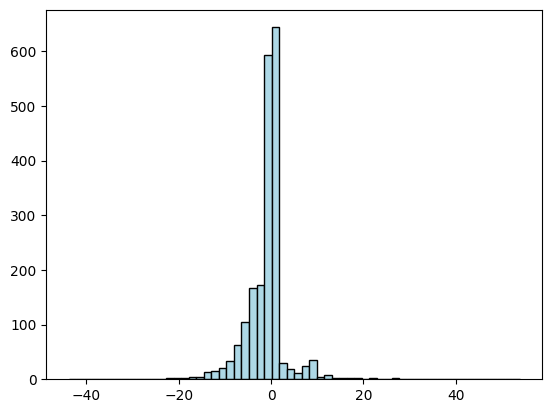

#AR  13  RMSE : 5.415702566222205
min: -44.566340326340324 , max :  54.05958041958042
Mode error:  -0.18467599067598428


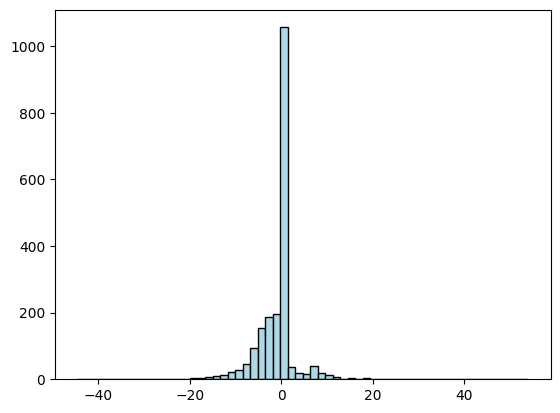

#AR  14  RMSE : 5.54715837579842
min: -45.16865800865801 , max :  54.29584415584416
Mode error:  -0.40963203463203257


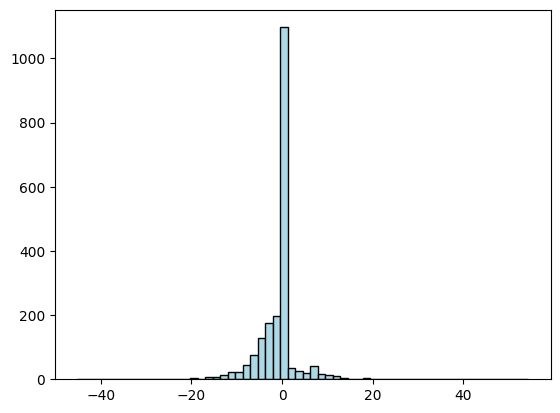

#AR  15  RMSE : 5.685605788977165
min: -45.690666666666665 , max :  54.50060606060606
Mode error:  -0.6045939393939435


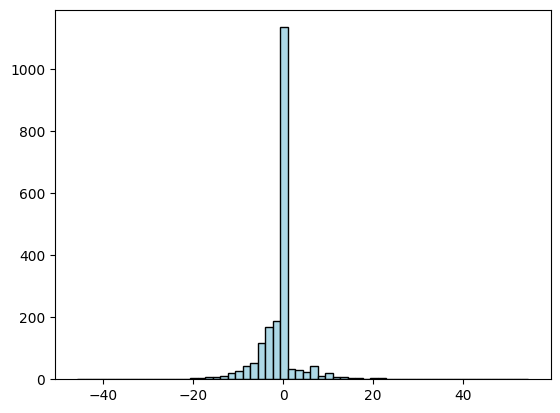

In [46]:
my_data_mean = []
for val in range(2,16):
    y_est,y_act,rms,est_freq, act_freq,eff_util,stall,energy= ModelPipeline_Mean(file,padding=pad,\
                                                                            endog=test_endog,N_CLUST=5,shiftAR=val,shiftARX=val,\
                                                                            trainIDX=TrIDX,testIDX=TIDX,TEST_LEN = TLEN)
    print("#AR ",val," RMSE :", rms)
    plotErrDist(y_est,y_act,60)
    data = (val,rms,stall,energy)
    my_data_mean.append(data)

Train Time:  0.3722733099712059
SVR: #AR  2  RMSE : 28.915596571814515
min: -69.56507024399843 , max :  22.748195787586212
Mode error:  -0.33012072030994943


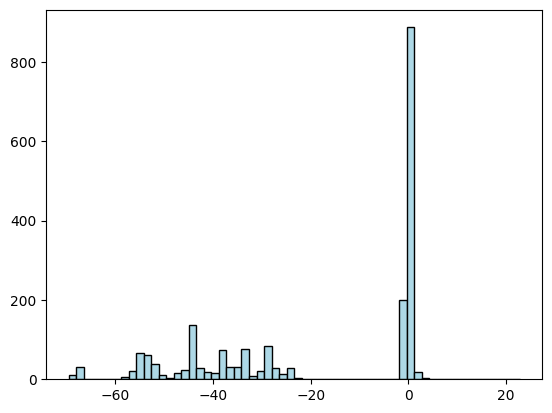

Train Time:  0.379501232993789
SVR: #AR  3  RMSE : 29.252216549095408
min: -69.81144307017212 , max :  22.146760820234128
Mode error:  -0.8427901523674279


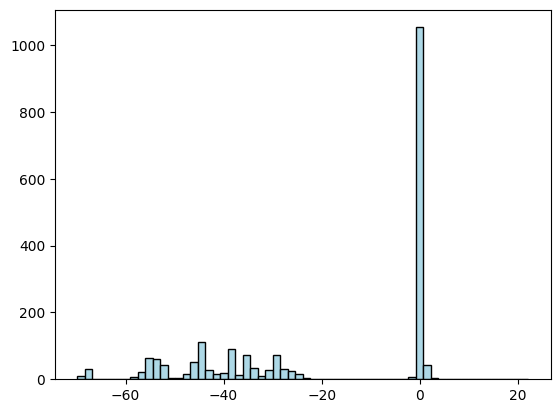

Train Time:  0.42450729198753834
SVR: #AR  4  RMSE : 28.708107498307317
min: -68.8916169532993 , max :  22.939233134418668
Mode error:  -0.018479387510822676


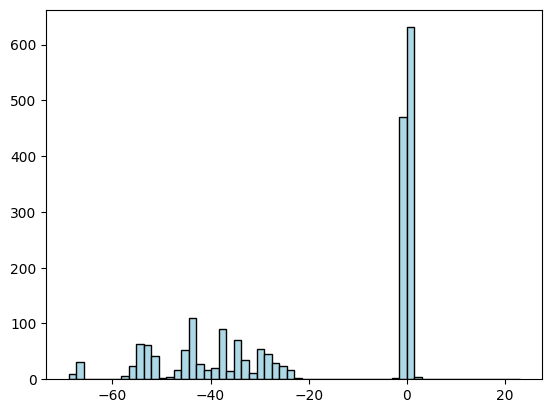

Train Time:  0.3538450279738754
SVR: #AR  5  RMSE : 28.26208884439867
min: -67.89573352812087 , max :  23.51098913711772
Mode error:  -0.8641369069459017


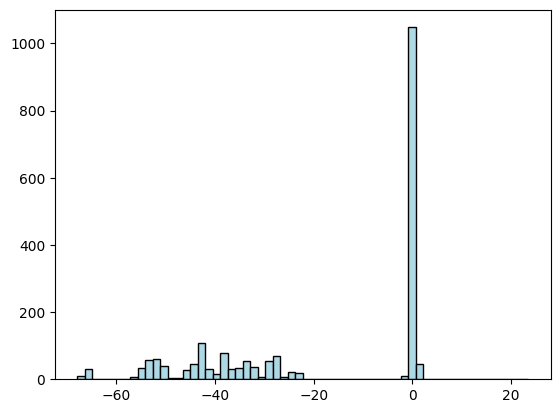

Train Time:  0.38337558903731406
SVR: #AR  6  RMSE : 27.951693062788575
min: -67.25676043400148 , max :  23.976049921501655
Mode error:  -0.35269950663250427


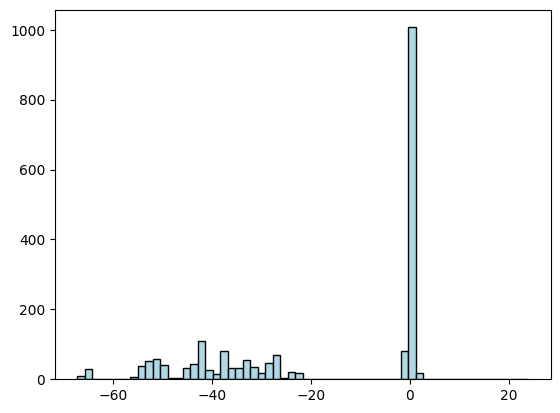

Train Time:  0.39987131603993475
SVR: #AR  7  RMSE : 27.648434649679317
min: -66.63770007887099 , max :  24.398218064346995
Mode error:  -1.395292076231442


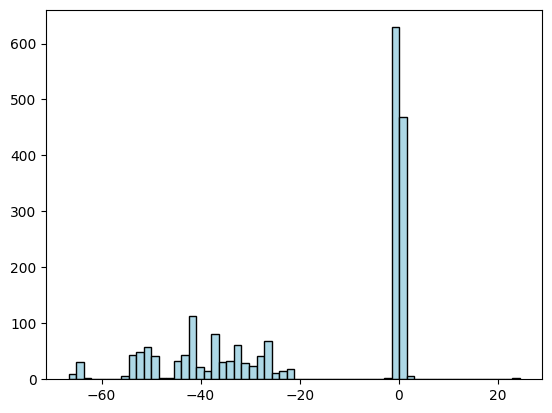

Train Time:  0.42516207497101277
SVR: #AR  8  RMSE : 27.448916867706707
min: -66.20972262984212 , max :  24.75165140847429
Mode error:  -1.0207379023820238


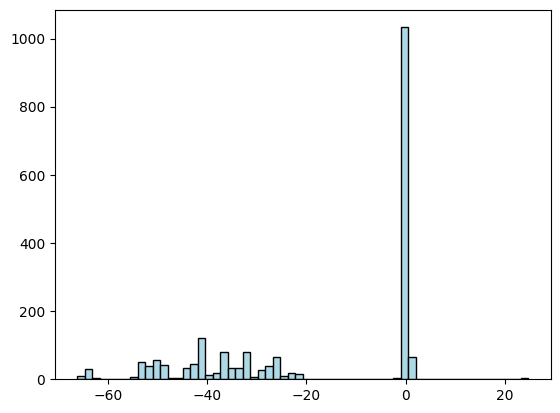

Train Time:  0.45966927893459797
SVR: #AR  9  RMSE : 27.531597952593142
min: -66.24969669644484 , max :  24.705599177184272
Mode error:  -1.06506798701065


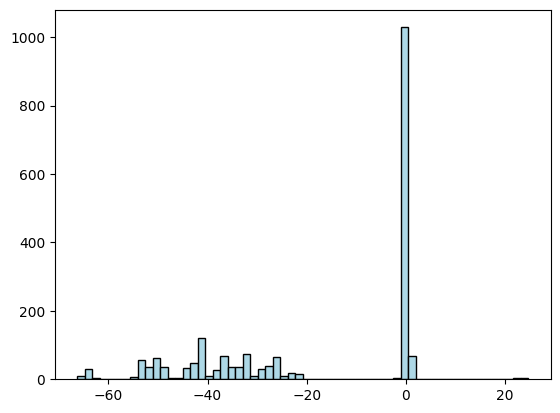

Train Time:  0.3751474489690736
SVR: #AR  10  RMSE : 27.77753922586339
min: -66.50903353645228 , max :  24.56352054129679
Mode error:  -1.2403697807321237


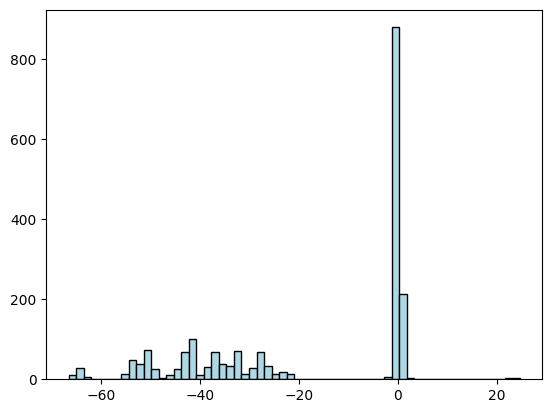

Train Time:  0.40553932695183903
SVR: #AR  11  RMSE : 27.803488043222348
min: -66.40761345779933 , max :  24.674871230679635
Mode error:  -1.131832764389415


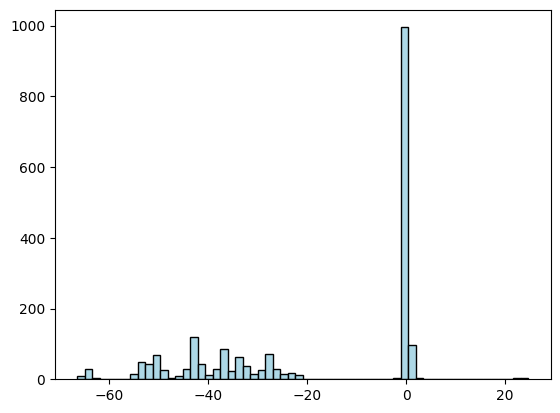

Train Time:  0.4227698550093919
SVR: #AR  12  RMSE : 28.345627150231273
min: -67.11822268090884 , max :  23.985693432304423
Mode error:  -0.30868419788578194


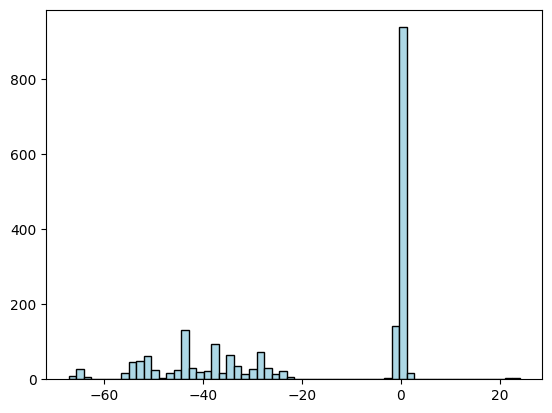

Train Time:  0.4449412840185687
SVR: #AR  13  RMSE : 28.815581023934453
min: -67.81552713425634 , max :  23.510767599826888
Mode error:  -0.8429109959286336


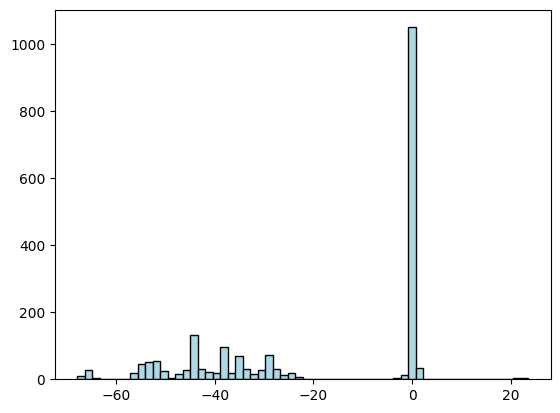

Train Time:  0.4792373439995572
SVR: #AR  14  RMSE : 29.270990864045224
min: -68.5113143056375 , max :  23.07870832860282
Mode error:  -1.3452977071946037


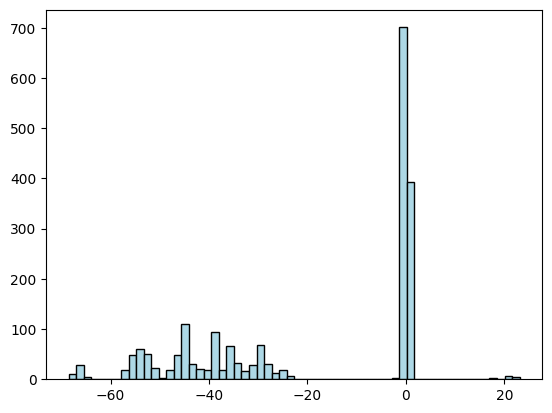

Train Time:  0.4944715249584988
SVR: #AR  15  RMSE : 29.673468798914374
min: -69.10311831964668 , max :  22.628577155451616
Mode error:  -0.30434671332297114


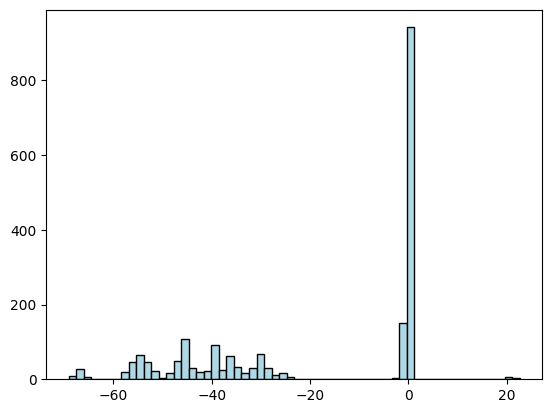

In [47]:
my_data_svr = []
for val in range(2,16):
    y_est,y_act,rms,est_freq, act_freq,eff_util,stall,energy= ModelPipeline_SVR(file,padding=pad,\
                                                                            endog=test_endog,Kernel='rbf',N_CLUST=0,\
                                                                            shiftAR=val,shiftARX=val,\
                                                                            trainIDX=TrIDX,testIDX=TIDX,TEST_LEN = TLEN)
    print("SVR: #AR ",val," RMSE :", rms)
    plotErrDist(y_est,y_act,60)
    data = (val,rms,stall,energy)
    my_data_svr.append(data)

Train Time:  32.684998737997375
LSTM: #AR  4  RMSE : 8.646094636036267
min: -42.33445739746094 , max :  43.945823669433594
Mode error:  -0.6323215484619169


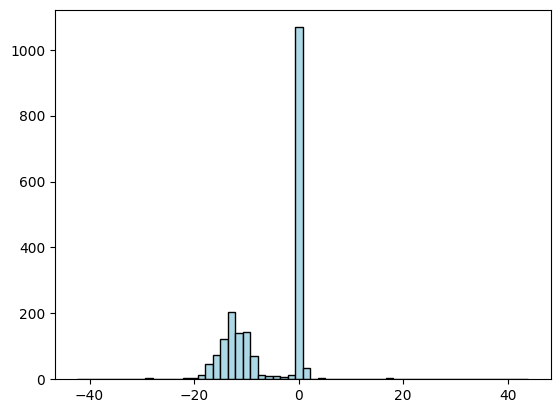

Train Time:  32.193498373031616
LSTM: #AR  6  RMSE : 4.335152343209435
min: -40.65915584564209 , max :  51.98292922973633
Mode error:  -0.5142523129781083


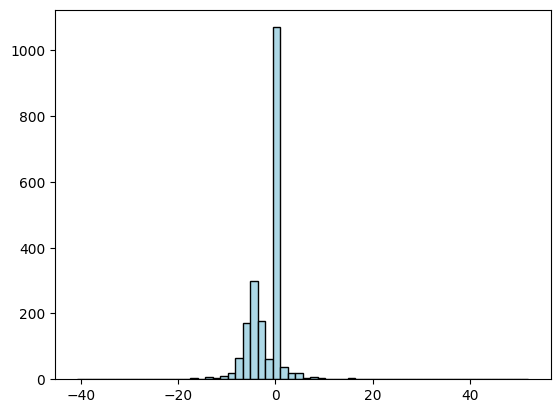

Train Time:  32.49258866393939
LSTM: #AR  8  RMSE : 5.123370192175991
min: -40.76526737213135 , max :  48.23955154418945
Mode error:  -0.7130988597869887


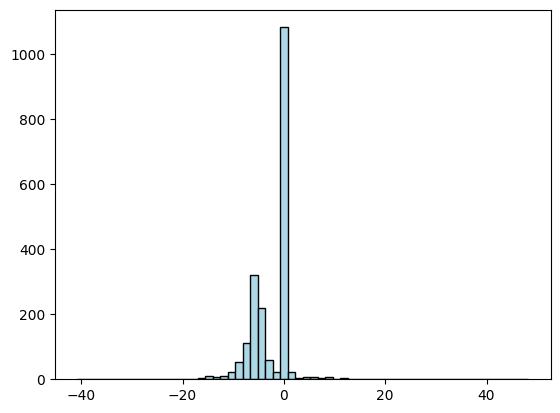

Train Time:  33.76034958800301
LSTM: #AR  10  RMSE : 13.289883555821634
min: -40.54323768615723 , max :  38.618512628728695
Mode error:  -0.9623625287142659


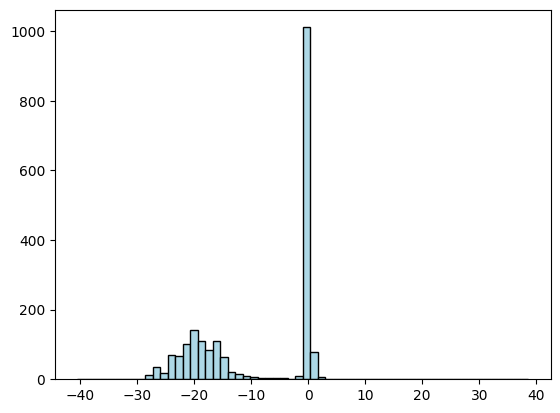

Train Time:  31.166503565968014
LSTM: #AR  12  RMSE : 10.9842148480267
min: -43.31499099731445 , max :  33.17416130759499
Mode error:  -1.2459572296142554


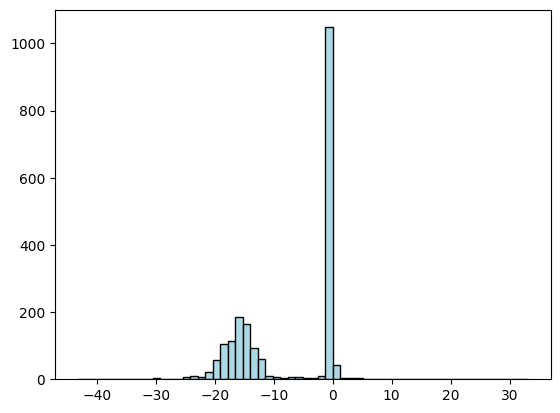

Train Time:  31.773370141047053
LSTM: #AR  14  RMSE : 9.916078563198298
min: -40.98417091369629 , max :  36.45855461814187
Mode error:  -0.9720960555799039


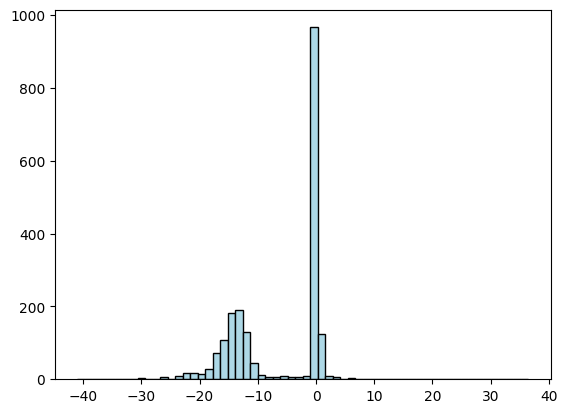

In [48]:
my_data_lstm = []
for val in range(4,16,2):
    y_est,y_act,rms,est_freq, act_freq,eff_util,stall,energy= ModelPipeline_LSTM(file,padding=pad,\
                                                                            endog=test_endog,N_CLUST=2,shiftAR=val,shiftARX=0,\
                                                                            trainIDX=TrIDX,testIDX=TIDX,TEST_LEN = TLEN)
    
    print("LSTM: #AR ",val," RMSE :", rms)
    plotErrDist(y_est,y_act,60)
    data = (val,rms,stall,energy)
    my_data_lstm.append(data)

In [49]:
my_data

[(2, 4.062721918738198, 0.5, 0.5002663208255584),
 (3, 3.460670228736561, 0.35, 0.49436391347410136),
 (4, 3.126956781443893, 0.3, 0.4848151098574941),
 (5, 3.1166907177455774, 0.3, 0.48495588702782133),
 (6, 3.3018414742527256, 0.35, 0.48639402550348687),
 (7, 3.258340113180974, 0.3, 0.4860070217032241),
 (8, 3.269628110616167, 0.3, 0.4865827194228014),
 (9, 3.2987037742789194, 0.3, 0.48732681125016597),
 (10, 3.3104804055836277, 0.3, 0.48752863419174564),
 (11, 3.4110792763883238, 0.35, 0.493632553031616),
 (12, 3.4187068154578295, 0.35, 0.4937552847273182),
 (13, 3.2037020927676663, 0.3, 0.48568789372640075),
 (14, 3.262808644496139, 0.35, 0.48147916610162544),
 (15, 3.307883027819501, 0.35, 0.4812624545819798)]

In [50]:
my_data_lstm

[(4, 8.646094636036267, 10.15, 0.49559058025900893),
 (6, 4.335152343209435, 0.6, 0.49386596673397254),
 (8, 5.123370192175991, 0.9, 0.5036745912782932),
 (10, 13.289883555821634, 19.45, 0.5080243811620258),
 (12, 10.9842148480267, 11.5, 0.5087846748591247),
 (14, 9.916078563198298, 10.95, 0.502300031163473)]

In [51]:
my_data_svr

[(2, 28.915596571814515, 43.6, 0.6211309764409043),
 (3, 29.252216549095408, 44.3, 0.6290192511236353),
 (4, 28.708107498307317, 42.75, 0.6213376290933255),
 (5, 28.26208884439867, 42.6, 0.6186014278642314),
 (6, 27.951693062788575, 42.6, 0.6171894563333831),
 (7, 27.648434649679317, 42.6, 0.6170609283134427),
 (8, 27.448916867706707, 42.6, 0.6162774384910188),
 (9, 27.531597952593142, 42.6, 0.6164494491582544),
 (10, 27.77753922586339, 42.6, 0.6170864546705632),
 (11, 27.803488043222348, 42.6, 0.6171000407128038),
 (12, 28.345627150231273, 42.7, 0.6177506835196164),
 (13, 28.815581023934453, 43.45, 0.6251401648374306),
 (14, 29.270990864045224, 44.3, 0.6421335958103318),
 (15, 29.673468798914374, 44.3, 0.6428892927952898)]

In [32]:
x = list(map(lambda x: x[0], my_data))
y = list(map(lambda x: x[3], my_data))
y_svr = list(map(lambda x: x[1], my_data_svr))
y_mean = list(map(lambda x: x[1], my_data_mean))

In [86]:
# ##Combined Plot
# plt.plot(x, y, label='Our Method') 
# # plt.plot(x, y_svr, label='SVR') 
# # plt.plot(x, y_mean, label='Mean') 

# plt.xlabel("AR") 
# plt.ylabel("Energy") 
# plt.title("Comparing Model") 
# plt.legend() 
# plt.show() 

## Mem Values

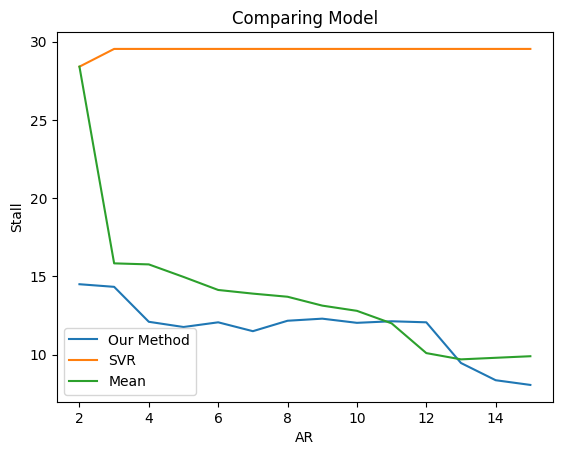

In [69]:
##Combined Plot
plt.plot(x, y, label='Our Method') 
plt.plot(x, y_svr, label='SVR') 
plt.plot(x, y_mean, label='Mean') 

plt.xlabel("AR") 
plt.ylabel("Stall") 
plt.title("Comparing Model") 
plt.legend() 
plt.show() 

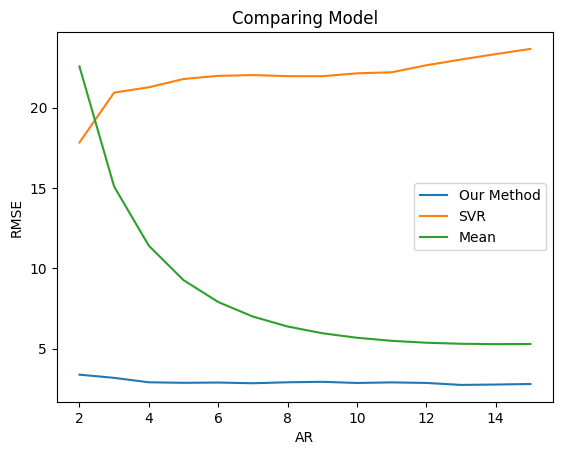

In [67]:
##Combined Plot
plt.plot(x, y, label='Our Method') 
plt.plot(x, y_svr, label='SVR') 
plt.plot(x, y_mean, label='Mean') 

plt.xlabel("AR") 
plt.ylabel("RMSE") 
plt.title("Comparing Model") 
plt.legend() 
plt.show() 

## CPU Values

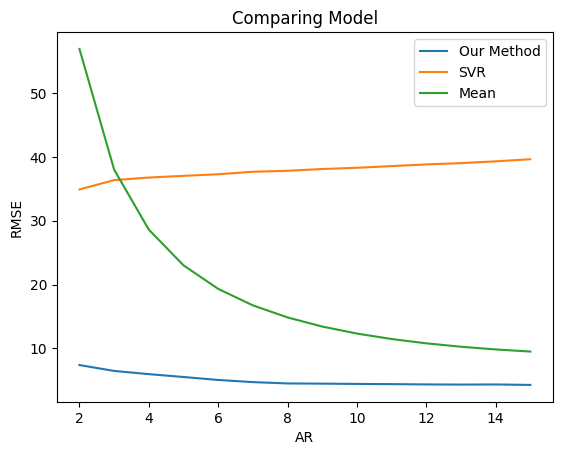

In [78]:
##Combined Plot
plt.plot(x, y, label='Our Method') 
plt.plot(x, y_svr, label='SVR') 
plt.plot(x, y_mean, label='Mean') 

plt.xlabel("AR") 
plt.ylabel("RMSE") 
plt.title("Comparing Model") 
plt.legend() 
plt.show()

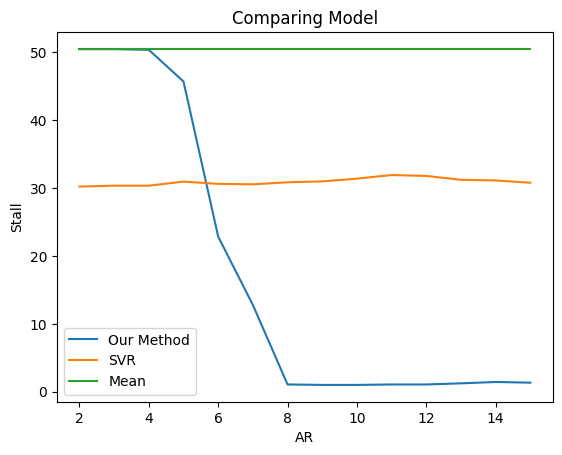

In [59]:
##Combined Plot
plt.plot(x, y, label='Our Method') 
plt.plot(x, y_svr, label='SVR') 
plt.plot(x, y_mean, label='Mean') 

plt.xlabel("AR") 
plt.ylabel("Stall") 
plt.title("Comparing Model") 
plt.legend() 
plt.show() 

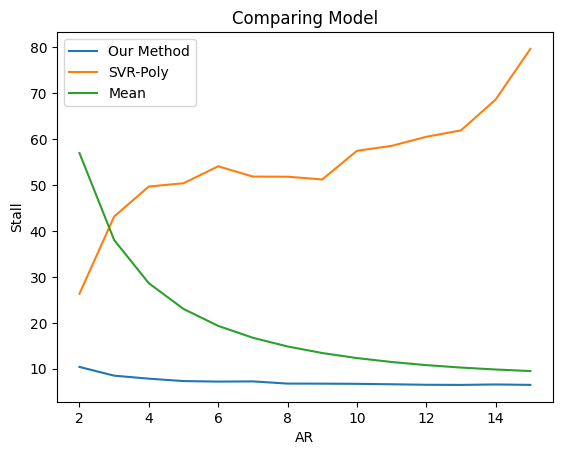

In [39]:
##Combined Plot
plt.plot(x, y, label='Our Method') 
plt.plot(x, y_svr, label='SVR-Poly') 
plt.plot(x, y_mean, label='Mean') 

plt.xlabel("AR") 
plt.ylabel("Stall") 
plt.title("Comparing Model") 
plt.legend() 
plt.show() 

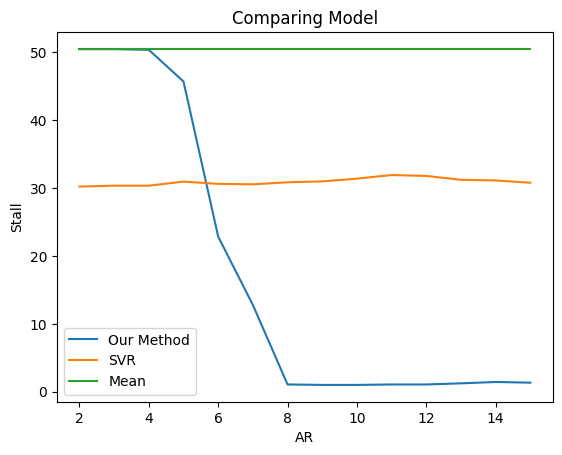

In [58]:
##Combined Plot
plt.plot(x, y, label='Our Method') 
plt.plot(x, y_svr, label='SVR') 
plt.plot(x, y_mean, label='Mean') 

plt.xlabel("AR") 
plt.ylabel("Stall") 
plt.title("Comparing Model") 
plt.legend() 
plt.show() 